In [35]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [36]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [37]:
# Função para aplicar equalização aleatória
def random_equalization(y, sr, n_bands=5, max_gain_db=12):
    # Cria um filtro de equalização aleatório
    frequencies = np.linspace(0, sr // 2, n_bands + 2)
    gains_db = np.random.uniform(-max_gain_db, max_gain_db, n_bands + 2)
    gains_linear = 10 ** (gains_db / 20)

    # Aplica o filtro
    y_eq = np.zeros_like(y)
    for i in range(len(frequencies) - 1):
        y_band = librosa.effects.preemphasis(y, coef=gains_linear[i])
        y_eq += y_band

    return y_eq

# Função para extrair MFCCs do áudio
def extract_features(y, sr):
    try:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.mean(mfccs.T, axis=0)  # Retorna a média dos coeficientes
    except Exception as e:
        print(f"Erro ao extrair MFCCs: {e}")
        return None

# Função para carregar dados e aplicar equalização aleatória
def load_data_with_random_equalization(folder_path, label):
    data = []
    labels = []

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        try:
            y, sr = librosa.load(file_path, sr=None)

            # Extrair features do áudio original
            features = extract_features(y, sr)
            if features is not None:
                data.append(features)
                labels.append(label)

            # Aplicar equalização aleatória
            y_eq = random_equalization(y, sr)
            features_eq = extract_features(y_eq, sr)

            if features_eq is not None:
                data.append(features_eq)
                labels.append(label)

        except Exception as e:
            print(f"Erro ao processar {file_path}: {e}")

    return data, labels

In [38]:
# Definir caminhos dos áudios
file_path_real = '/content/drive/MyDrive/audios_FOR/real'
file_path_fake = '/content/drive/MyDrive/audios_FOR/fake'

# Criar diretórios se não existirem
os.makedirs(file_path_real, exist_ok=True)
os.makedirs(file_path_fake, exist_ok=True)

# Carregar dados com ruído
data_real, labels_real = load_data_with_random_equalization(file_path_real, label=1)  # Áudios reais
data_fake, labels_fake = load_data_with_random_equalization(file_path_fake, label=0)  # Áudios falsos

# Unir dados reais e falsos
data = data_real + data_fake
labels = labels_real + labels_fake

# Remover valores None
data_filtered, labels_filtered = zip(*[(d, l) for d, l in zip(data, labels) if d is not None])

In [39]:
# Criar DataFrame
df = pd.DataFrame(data_filtered)
df['label'] = labels_filtered

In [40]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,label
0,-255.816910,112.393753,35.184296,45.455238,0.735206,12.198413,2.518530,1.802739,-5.389248,9.323727,-5.831278,1.273910,-10.684999,1
1,-133.960709,37.489346,22.114140,39.572380,-8.008802,11.142028,-3.772429,4.435091,-9.727532,12.841870,-9.646096,3.678617,-14.970192,1
2,-427.382538,120.644302,-50.988857,43.591103,-2.027257,19.382067,-20.916830,-0.882401,-4.035796,-16.009333,11.646186,-9.559209,-1.221460,1
3,-328.963684,45.792477,-41.334015,41.183121,-0.580013,17.350616,-19.509562,-2.691641,-2.000938,-18.138058,13.565996,-10.810985,-0.852273,1
4,-323.788910,76.595367,10.701393,27.860157,-11.603580,-21.503466,-11.118139,-20.747959,-23.567154,-4.115427,-13.861460,-2.845701,-17.429346,1


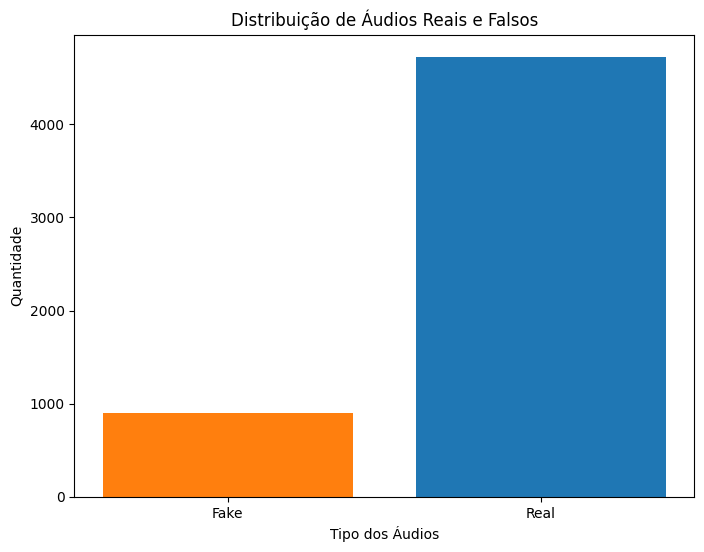

In [41]:
# Visualizar distribuição dos rótulos
plt.figure(figsize=(8, 6))
plt.bar(df['label'].value_counts().index, df['label'].value_counts().values, tick_label=['Real', 'Fake'], color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Tipo dos Áudios')
plt.ylabel('Quantidade')
plt.title('Distribuição de Áudios Reais e Falsos')
plt.show()

In [42]:
df.shape

(5622, 14)

In [43]:
# Separar características (X) e rótulos (y)
X = df.drop(columns=['label'])
y = df['label']

In [44]:
# Função para calcular e exibir as métricas
def print_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("\n")

In [45]:
# Dividir em treino e teste
X_train_rf_model, X_test_rf_model, y_train_rf_model, y_test_rf_model = train_test_split(X, y, test_size=0.2, random_state=1)

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=1)
rf_model.fit(X_train_rf_model, y_train_rf_model)
rf_pred = rf_model.predict(X_test_rf_model)
print("Random Forest:")
print_metrics(y_test_rf_model, rf_pred)

Random Forest:
Acurácia: 0.88
Precisão: 0.94
Recall: 0.92
F1-Score: 0.93




In [46]:
# Dividir em treino e teste
X_train_lgb_model, X_test_lgb_model, y_train_lgb_model, y_test_lgb_model = train_test_split(X, y, test_size=0.2, random_state=2)

# 2. LightGBM
lgb_model = lgb.LGBMClassifier(verbose=-1)
lgb_model.fit(X_train_lgb_model, y_train_lgb_model)
lgb_pred = lgb_model.predict(X_test_lgb_model)
print("LightGBM:")
print_metrics(y_test_lgb_model, lgb_pred)

LightGBM:
Acurácia: 0.95
Precisão: 0.96
Recall: 0.99
F1-Score: 0.97




In [47]:
# Dividir em treino e teste
X_train_nb_model, X_test_nb_model, y_train_nb_model, y_test_nb_model = train_test_split(X, y, test_size=0.2, random_state=3)

# 3. Naïve Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_nb_model, y_train_nb_model)
nb_pred = nb_model.predict(X_test_nb_model)
print("Naïve Bayes:")
print_metrics(y_test_nb_model, nb_pred)

Naïve Bayes:
Acurácia: 0.88
Precisão: 0.94
Recall: 0.92
F1-Score: 0.93




In [48]:
# Dividir em treino e teste
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=4)

# Padronização dos dados para LSTM e KNN
scaler = StandardScaler()
X_train_scaled_lstm = scaler.fit_transform(X_train_lstm)
X_test_scaled_lstm = scaler.transform(X_test_lstm)

# 4. LSTM
X_train_lstm = X_train_scaled_lstm.reshape(-1, 1, X_train_scaled_lstm.shape[1])
X_test_lstm = X_test_scaled_lstm.reshape(-1, 1, X_test_scaled_lstm.shape[1])

lstm_model = Sequential()
lstm_model.add(LSTM(units=1, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, verbose=0)
lstm_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype("int64")
print("LSTM:")
print_metrics(y_test_lstm, lstm_pred)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
LSTM:
Acurácia: 0.86
Precisão: 0.90
Recall: 0.94
F1-Score: 0.92




In [49]:
# Dividir em treino e teste
X_train_knn_model, X_test_knn_model, y_train_knn_model, y_test_knn_model = train_test_split(X, y, test_size=0.2, random_state=5)

# 5. KNN
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train_knn_model, y_train_knn_model)
knn_pred = knn_model.predict(X_test_knn_model)
print("KNN:")
print_metrics(y_test_knn_model, knn_pred)

KNN:
Acurácia: 0.93
Precisão: 0.97
Recall: 0.95
F1-Score: 0.96


